In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
import pickle

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">

This notebook gets the embeddings provided by transE.ipynb and trains an MLP using those and the price group as the target.

First, we load the previous objects

In [4]:
with open('./objects/train.pkl', 'rb') as outp:
    train = pickle.load(outp)

with open('./objects/kg_train.pkl', 'rb') as outp:
    kg_train = pickle.load(outp)

with open('./objects/test_X.pkl', 'rb') as outp:
    test_X = pickle.load(outp)

with open('./objects/test_y.pkl', 'rb') as outp:
    test_y = pickle.load(outp)

with open('./objects/model.pkl', 'rb') as outp:
    model = pickle.load(outp)

C:\Users\sergi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchkge\utils\data_redundancy.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Data Preparation

In [5]:
batch_size = 1000  # Adjust batch size according to your memory capacity

filtered_items = train[train['rel'] == 'http://example.org/apartment/price_discretized']['from']

train_embedding_list = [np.load(f'./train_X/batch_{start}.npy') for start in range(0, len(filtered_items), batch_size)]
train_embedding_list = np.concatenate(train_embedding_list, axis=0)
train_embedding_tensor = torch.tensor(train_embedding_list, dtype=torch.float32)

In [6]:
train_X = train_embedding_tensor
train_y = train[train['rel'] == 'http://example.org/apartment/price_discretized']['to']
train_y = torch.tensor(train_y.astype(float).array)

In [30]:
batch_size = 500  # Adjust batch size according to your memory capacity

filtered_items = test_X['from']

test_embedding_list = [np.load(f'./test_X/batch_{start}.npy') for start in range(0, len(filtered_items), batch_size)]
test_embedding_list = np.concatenate(test_embedding_list, axis=0)
test_embedding_tensor = torch.tensor(test_embedding_list, dtype=torch.float32)

In [36]:
test_X = test_embedding_tensor
test_y = torch.tensor(test_y.astype(float).array)

MLP Training

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Definición del modelo MLP
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Parámetros del modelo
input_size = train_X.shape[1]
hidden_size = 128
output_size = 4 # ya que los posibles valores de test_y son 0, 1, 2, 3

# Instanciar el modelo, el criterio de pérdida y el optimizador
model = MLPClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir train_y y test_y al tipo Long
train_y = train_y.long()
test_y = test_y.long()

# Entrenamiento del modelo
num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluación del modelo
model.eval()
with torch.no_grad():
    train_outputs = model(train_X)
    train_predictions = torch.argmax(train_outputs, dim=1)
    train_accuracy = accuracy_score(train_y.numpy(), train_predictions.numpy())

    test_outputs = model(test_X)
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_accuracy = accuracy_score(test_y.numpy(), test_predictions.numpy())

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [2/80], Loss: 1.4082
Epoch [4/80], Loss: 1.3870
Epoch [6/80], Loss: 1.3665
Epoch [8/80], Loss: 1.3459
Epoch [10/80], Loss: 1.3240
Epoch [12/80], Loss: 1.2999
Epoch [14/80], Loss: 1.2733
Epoch [16/80], Loss: 1.2439
Epoch [18/80], Loss: 1.2124
Epoch [20/80], Loss: 1.1801
Epoch [22/80], Loss: 1.1497
Epoch [24/80], Loss: 1.1243
Epoch [26/80], Loss: 1.1072
Epoch [28/80], Loss: 1.0996
Epoch [30/80], Loss: 1.0990
Epoch [32/80], Loss: 1.1009
Epoch [34/80], Loss: 1.1014
Epoch [36/80], Loss: 1.0986
Epoch [38/80], Loss: 1.0927
Epoch [40/80], Loss: 1.0855
Epoch [42/80], Loss: 1.0791
Epoch [44/80], Loss: 1.0746
Epoch [46/80], Loss: 1.0717
Epoch [48/80], Loss: 1.0695
Epoch [50/80], Loss: 1.0671
Epoch [52/80], Loss: 1.0640
Epoch [54/80], Loss: 1.0601
Epoch [56/80], Loss: 1.0557
Epoch [58/80], Loss: 1.0510
Epoch [60/80], Loss: 1.0464
Epoch [62/80], Loss: 1.0419
Epoch [64/80], Loss: 1.0374
Epoch [66/80], Loss: 1.0329
Epoch [68/80], Loss: 1.0283
Epoch [70/80], Loss: 1.0238
Epoch [72/80], Loss: 1.0

In [50]:
x = pd.Series(test_predictions)

In [66]:
x.value_counts()

1    1065
0     796
2      85
3      39
dtype: int64

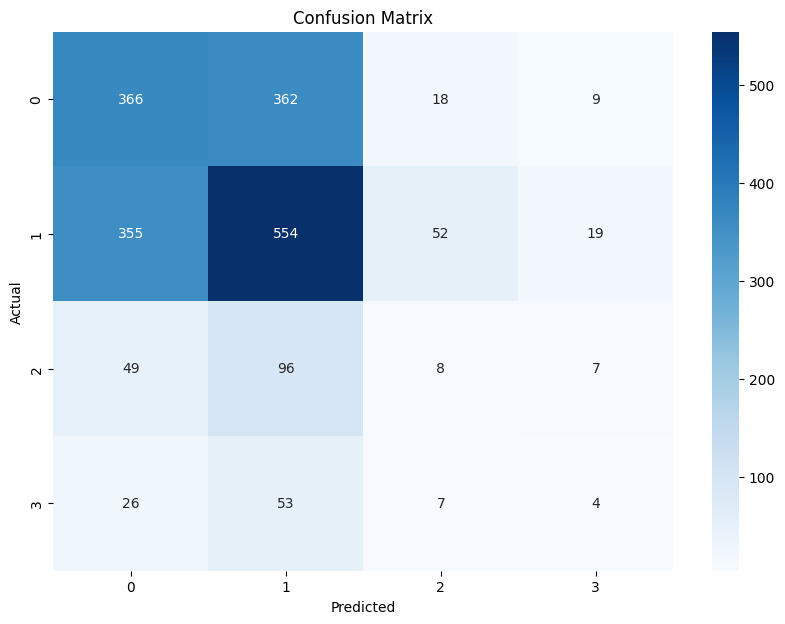

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(test_y, test_predictions)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

As it is, the model is not the world's best predictor. Although it is better than the random baseline (which would be 25% accuracy), it rarely predicts the 2 most expensive classes and when it does it usually does it very badly. 

On experimentation, we have found that with the actual data, these are the best results before the model starts overfitting. This might be due to data unexplicability (not probable), not enoguh data instances, a bad embedder (TransE) caused by, for instance, a too little embedding dimension.

In [62]:
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>